In [35]:
from tsfresh.examples import load_robot_execution_failures
import pandas as pd
import tsfresh
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from ML.feature_selection import FeatureSelection
from ML.model import Model, min_acc
from ML.process_data import Data
from utils.help_classes import ScalerEnum, ModelsEnum
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler

from utils.help_classes import ModelsEnum
from sklearn.model_selection import train_test_split
import os
import datetime
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pickle
import numpy as np
import category_encoders as ce
import plotly_express as px
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from numpy.linalg import LinAlgError

In [2]:
X = pd.read_csv(os.path.join('data_csv', 'features_train.csv'))
X['time_stamp'] = pd.to_datetime(X['time_stamp'])

In [17]:
X_train = X.loc[X['time_stamp'] < X['time_stamp'].quantile(q=0.95)]
X_val = X.loc[X['time_stamp'] >= X['time_stamp'].quantile(q=0.95)]

In [18]:
print('X_train', X_train.shape)
print('X_val', X_val.shape)

X_train (31104, 56)
X_val (1637, 56)


In [5]:
y_train = X_train['label']
X_train = X_train.drop(columns=['label', 'time_stamp', 'traj'])

y_val = X_val['label']
X_val = X_val.drop(columns=['label', 'time_stamp', 'traj'])

In [6]:
print('before sampling', X_train.shape)
X_train = X_train.fillna(X_train.mean())

sampling_strategy = "not minority"
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_train, y_train = rus.fit_resample(X_train, y_train)
print('after sampling', X_train.shape)

before sampling (29466, 53)
after sampling (6381, 53)


In [7]:
X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_val.median())

In [8]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [11]:
ml_model = Model(model_name="time_series_4_" + str(ModelsEnum.Xgboost), classifier_method=ModelsEnum.Xgboost, 
                 verbose=True, binary_task=False,  write_csv=True, class_weight=class_weight)

trained_model, results_train = ml_model.cross_fold_validation(X_train, y_train, grid_search=False, cv=3, 
                                                              n_iter=10, scoring=make_scorer(min_acc), n_jobs=2)
results_dict = ml_model.test_set(X_val, y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'accuracy': [0.945648854961832], 'f1_': [0.9374639048550811], 'jaccard': [0.8969012452939473], 'recall': [0.945648854961832], 'min_acc': [0.9299516908212561], 'acc_0': [0.9476510067114094], 'acc_1': [0.9299516908212561], 'acc_2': [0.9858490566037735]}


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


## Examine predictions on test set (acc_0=94, acc_1=93, acc-2=95)

In [13]:
predictions_proba = pd.read_csv('probas_PseudoLabelling.csv')
print(predictions_proba.shape)
print(predictions_proba.columns)

(8185, 4)
Index(['trajectory_ind', 'final_prediction_proba_0',
       'final_prediction_proba_1', 'final_prediction_proba_2'],
      dtype='object')


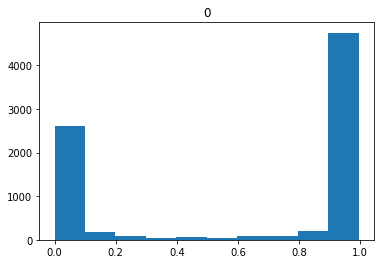

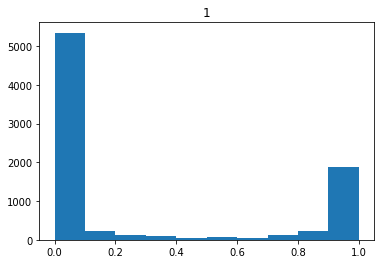

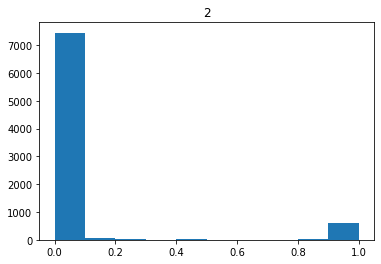

In [15]:
plt.figure()
plt.hist(predictions_proba.final_prediction_proba_0)
plt.title('0')
plt.show()

plt.figure()
plt.hist(predictions_proba.final_prediction_proba_1)
plt.title('1')
plt.show()

plt.figure()
plt.hist(predictions_proba.final_prediction_proba_2)
plt.title('2')
plt.show()

In [16]:
predictions_proba_val = pd.read_csv('probas_PseudoLabelling_val.csv')
print(predictions_proba_val.shape)
print(predictions_proba_val.columns)

(1637, 4)
Index(['trajectory_ind', 'final_prediction_proba_0',
       'final_prediction_proba_1', 'final_prediction_proba_2'],
      dtype='object')


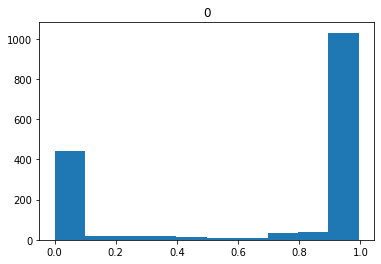

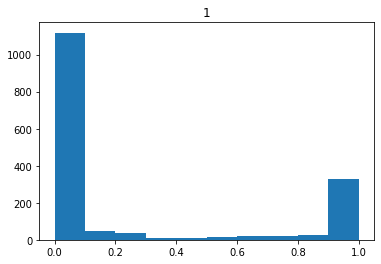

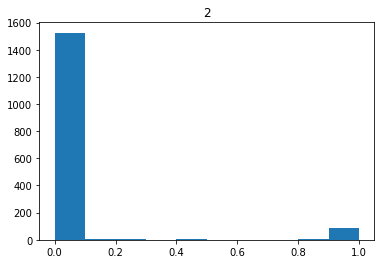

In [19]:
plt.figure()
plt.hist(predictions_proba_val.final_prediction_proba_0)
plt.title('0')
plt.show()

plt.figure()
plt.hist(predictions_proba_val.final_prediction_proba_1)
plt.title('1')
plt.show()

plt.figure()
plt.hist(predictions_proba_val.final_prediction_proba_2)
plt.title('2')
plt.show()

## Check on validation set

In [34]:
threshold_0, threshold_1, threshold_2 = 0.9, 0.6, 0.9

In [35]:
traj_add, label_add = [], []
for proba_0, proba_1, proba_2, traj in zip(predictions_proba_val.final_prediction_proba_0,  
                                           predictions_proba_val.final_prediction_proba_1,  
                                           predictions_proba_val.final_prediction_proba_2, 
                                           predictions_proba_val.trajectory_ind):
    if proba_0 > threshold_0:
        traj_add.append(traj)
        label_add.append(0)
    if proba_1 > threshold_1:
        traj_add.append(traj)
        label_add.append(1)
    if proba_2 > threshold_2:
        traj_add.append(traj)
        label_add.append(2)

In [36]:
len(traj_add)

1517

In [37]:
X = pd.read_csv(os.path.join('data_csv', 'features_train.csv'))
X['time_stamp'] = pd.to_datetime(X['time_stamp'])

X_train = X.loc[X['time_stamp'] < X['time_stamp'].quantile(q=0.95)]
X_val = X.loc[X['time_stamp'] >= X['time_stamp'].quantile(q=0.95)]

print('X_train', X_train.shape)
print('X_val', X_val.shape)

X_train (31104, 56)
X_val (1637, 56)


In [38]:
X_add = X_val.loc[X_val['traj'].isin(traj_add)]
print('X_add', X_add.shape)

X_train_new = pd.concat([X_train, X_add])
print('X_train_new', X_train_new.shape)

X_add (1517, 56)
X_train_new (32621, 56)


In [39]:
y_train_new = X_train_new['label']
X_train_new = X_train_new.drop(columns=['label', 'time_stamp', 'traj'])

y_val = X_val['label']
X_val = X_val.drop(columns=['label', 'time_stamp', 'traj'])

X_train_new = X_train_new.fillna(X_train.median())
X_val = X_val.fillna(X_val.median())

scaler = MinMaxScaler()
scaler.fit(X_train_new)
X_train_new = scaler.transform(X_train_new)
X_val = scaler.transform(X_val)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [40]:
ml_model = Model(model_name="time_series_4_" + str(ModelsEnum.Xgboost), classifier_method=ModelsEnum.Xgboost, 
                 verbose=True, binary_task=False,  write_csv=True, class_weight=class_weight)

trained_model, results_train = ml_model.cross_fold_validation(X_train_new, y_train_new, grid_search=False, cv=3, 
                                                              n_iter=10, scoring=make_scorer(min_acc), n_jobs=2)
results_dict = ml_model.test_set(X_val, y_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'accuracy': [0.9957238851557727], 'f1_': [0.9959071067903739], 'jaccard': [0.9914841849148418], 'recall': [0.9957238851557727], 'min_acc': [0.9893899204244032], 'acc_0': [0.9974424552429667], 'acc_1': [0.9893899204244032], 'acc_2': [1.0]}


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


## PseudoLabelling on test set

In [3]:
X_train = pd.read_csv(os.path.join('data_csv', 'features_train.csv'))
X_train['time_stamp'] = pd.to_datetime(X_train['time_stamp'])

X_test = pd.read_csv(os.path.join('data_csv', 'features_test.csv'))
X_test['time_stamp'] = pd.to_datetime(X_test['time_stamp'])

print('X_train', X_train.shape)
print('X_test', X_test.shape)

X_train (32741, 56)
X_test (8185, 56)


In [4]:
X_train.head()

,label,traj,time_stamp,coefs_0,coefs_1,coefs_2,higher_z,initial_point_x,initial_point_y,final_point_x,...,coefs_x_2,coefs_y_0,coefs_y_1,coefs_y_2,coefs_z_0,coefs_z_1,coefs_z_2,pos,speed,acc
0,1,0,2015-12-29 14:50:34.045000,-1.825034,-0.203164,0.071941,0.077547,0.750917,-0.234958,0.836562,...,0.814846,-0.008371,-0.235226,0.023523,-0.113428,0.062726,0.068913,0.119786,0.260194,0.818093
1,1,1,2015-12-29 14:50:35.846440,-1.825034,-0.203164,0.071941,0.077547,0.750917,-0.234958,0.836562,...,0.814846,-0.008371,-0.235226,0.023523,-0.113428,0.062726,0.068913,0.119786,0.260194,0.818093
2,1,2,2015-12-29 14:50:37.647880,-1.825034,-0.203164,0.071941,0.077547,0.750917,-0.234958,0.836562,...,0.814846,-0.008371,-0.235226,0.023523,-0.113428,0.062726,0.068913,0.119786,0.260194,0.818093
3,1,3,2015-12-29 14:50:39.449320,-1.825034,-0.203164,0.071941,0.077547,0.750917,-0.234958,0.836562,...,0.814846,-0.008371,-0.235226,0.023523,-0.113428,0.062726,0.068913,0.119786,0.260194,0.818093
4,1,4,2013-08-23 23:46:53.847000,-2.742992,0.252271,0.079860,0.085605,0.896362,0.115318,1.230456,...,0.972505,-0.001629,0.009646,0.141864,-0.023579,0.045637,0.063285,0.023646,0.096122,0.984833


In [5]:
X_test.head()

,label,traj,time_stamp,coefs_0,coefs_1,coefs_2,higher_z,initial_point_x,initial_point_y,final_point_x,...,coefs_x_2,coefs_y_0,coefs_y_1,coefs_y_2,coefs_z_0,coefs_z_1,coefs_z_2,pos,speed,acc
0,0,32741,2013-04-20 05:09:02.116671,-8.079544,-0.298613,0.018610,0.020802,0.610764,0.102281,0.522912,...,0.550384,0.001547,0.014510,0.087032,-0.028459,0.009857,0.020106,0.032109,0.076993,0.557585
1,0,32742,2013-04-20 05:09:06.492507,-8.079544,-0.298613,0.018610,0.020802,0.610764,0.102281,0.522912,...,0.552937,0.004682,0.011009,0.087594,-0.031394,0.012550,0.020026,0.031809,0.062766,0.560190
2,0,32743,2013-04-20 05:09:10.868343,-8.079544,-0.298613,0.018610,0.020802,0.610764,0.102281,0.522912,...,0.551058,0.002960,0.013039,0.087207,-0.030987,0.012198,0.019904,0.032594,0.071817,0.558271
3,0,32744,2014-05-26 21:35:59.466000,-5.315356,-0.322977,0.039872,0.044778,0.689315,0.012985,0.513822,...,0.574530,0.013452,-0.041563,0.043278,-0.073638,0.035063,0.040767,0.074938,0.122885,0.577598
4,0,32745,2014-05-26 21:36:03.119319,-5.315356,-0.322977,0.039872,0.044778,0.689315,0.012985,0.513822,...,0.576408,0.012462,-0.039958,0.042554,-0.070258,0.030863,0.041550,0.071525,0.118588,0.579469


In [6]:
predictions_proba = pd.read_csv('probas_PseudoLabelling.csv')
print(predictions_proba.shape)
print(predictions_proba.columns)

(8185, 4)
Index(['trajectory_ind', 'final_prediction_proba_0',
       'final_prediction_proba_1', 'final_prediction_proba_2'],
      dtype='object')


In [7]:
traj_add, label_add = [], []
threshold_0, threshold_1, threshold_2 = 0.9, 0.6, 0.9


for proba_0, proba_1, proba_2, traj in zip(predictions_proba.final_prediction_proba_0,  
                                           predictions_proba.final_prediction_proba_1,  
                                           predictions_proba.final_prediction_proba_2, 
                                           predictions_proba.trajectory_ind):
    if proba_0 > threshold_0:
        traj_add.append(traj)
        label_add.append(0)
    if proba_1 > threshold_1:
        traj_add.append(traj)
        label_add.append(1)
    if proba_2 > threshold_2:
        traj_add.append(traj)
        label_add.append(2)

In [8]:
len(traj_add)

7614

In [9]:
X_add = X_test.loc[X_test['traj'].isin(traj_add)]
print('X_add', X_add.shape)

X_add['label'] = label_add

X_train_new = pd.concat([X_train, X_add])
print('X_train_new', X_train_new.shape)

X_add (7614, 56)
X_train_new (40355, 56)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
X_test.head()

,label,traj,time_stamp,coefs_0,coefs_1,coefs_2,higher_z,initial_point_x,initial_point_y,final_point_x,...,coefs_x_2,coefs_y_0,coefs_y_1,coefs_y_2,coefs_z_0,coefs_z_1,coefs_z_2,pos,speed,acc
0,0,32741,2013-04-20 05:09:02.116671,-8.079544,-0.298613,0.018610,0.020802,0.610764,0.102281,0.522912,...,0.550384,0.001547,0.014510,0.087032,-0.028459,0.009857,0.020106,0.032109,0.076993,0.557585
1,0,32742,2013-04-20 05:09:06.492507,-8.079544,-0.298613,0.018610,0.020802,0.610764,0.102281,0.522912,...,0.552937,0.004682,0.011009,0.087594,-0.031394,0.012550,0.020026,0.031809,0.062766,0.560190
2,0,32743,2013-04-20 05:09:10.868343,-8.079544,-0.298613,0.018610,0.020802,0.610764,0.102281,0.522912,...,0.551058,0.002960,0.013039,0.087207,-0.030987,0.012198,0.019904,0.032594,0.071817,0.558271
3,0,32744,2014-05-26 21:35:59.466000,-5.315356,-0.322977,0.039872,0.044778,0.689315,0.012985,0.513822,...,0.574530,0.013452,-0.041563,0.043278,-0.073638,0.035063,0.040767,0.074938,0.122885,0.577598
4,0,32745,2014-05-26 21:36:03.119319,-5.315356,-0.322977,0.039872,0.044778,0.689315,0.012985,0.513822,...,0.576408,0.012462,-0.039958,0.042554,-0.070258,0.030863,0.041550,0.071525,0.118588,0.579469


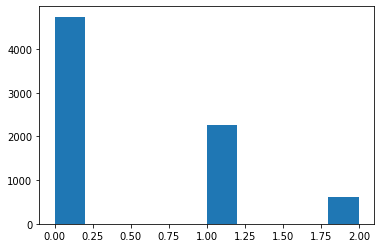

In [14]:
plt.figure()
plt.hist(X_add.label)
plt.show()

In [15]:
y_train_new = X_train_new['label']
X_train_new = X_train_new.drop(columns=['label', 'time_stamp', 'traj'])

X_train_new = X_train_new.fillna(X_train_new.median())

scaler = MinMaxScaler()
scaler.fit(X_train_new)
X_train_new = scaler.transform(X_train_new)

In [16]:
class_weight = {0: 0.3, 1: 3, 2: 2}

In [17]:
ml_model = Model(model_name="time_series_4_" + str(ModelsEnum.Xgboost), classifier_method=ModelsEnum.Xgboost, 
                 verbose=True, binary_task=False,  write_csv=True, class_weight=class_weight)

trained_model, results_train = ml_model.cross_fold_validation(X_train_new, y_train_new, grid_search=False, cv=3, 
                                                              n_iter=50, scoring=make_scorer(min_acc), n_jobs=2)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


## Check output

In [18]:
results_dict = ml_model.test_set(X_train_new, y_train_new)

{'accuracy': [0.9999504398463636], 'f1_': [0.9998541596812336], 'jaccard': [0.9999008846049012], 'recall': [0.9999504398463636], 'min_acc': [0.9993211133740665], 'acc_0': [1.0], 'acc_1': [1.0], 'acc_2': [0.9993211133740665]}


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [ ]:
results_dict = ml_model.test_set(X_train_new, y_train_new)

## Test set

In [19]:
X_test = pd.read_csv(os.path.join('data_csv', 'features_test.csv'))

In [20]:
traj = X_test['traj'].values

In [21]:
X_test = X_test.drop(columns=['label', 'time_stamp', 'traj'])
X_test = X_test.fillna(X_test.median())
X_test = scaler.transform(X_test)

In [22]:
final_prediction = trained_model.predict(X_test)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [23]:
test_predictions = pd.DataFrame({
        'trajectory_ind': traj,
        'label': final_prediction
    })
test_predictions.to_csv('submission_5.csv', index=False)

## Check submission

In [36]:
submission_3 = pd.read_csv('submission_3_EnsembleLearning.csv')

In [37]:
submission_5 = pd.read_csv('submission_5.csv')

In [38]:
y_test = submission_3.label
y_pred = submission_5.label

In [39]:
from sklearn import neighbors, svm, metrics

y_true_0 = y_test[y_test == 0]
y_pred_0 = y_pred[y_test == 0]

y_true_1 = y_test[y_test == 1]
y_pred_1 = y_pred[y_test == 1]

y_true_2 = y_test[y_test == 2]
y_pred_2 = y_pred[y_test == 2]

acc_0 = metrics.accuracy_score(y_true_0, y_pred_0)
acc_1 = metrics.accuracy_score(y_true_1, y_pred_1)
acc_2 = metrics.accuracy_score(y_true_2, y_pred_2)

results_dict = {
    "accuracy": [metrics.accuracy_score(y_test, y_pred)],
    'min_acc': [min_acc(y_test, y_pred)],
    'acc_0': [acc_0],
    'acc_1': [acc_1],
    'acc_2': [acc_2],
}

In [40]:
results_dict

{'accuracy': [0.9879047037263287],
 'min_acc': [0.9753846153846154],
 'acc_0': [0.9901753034097477],
 'acc_1': [0.9863481228668942],
 'acc_2': [0.9753846153846154]}

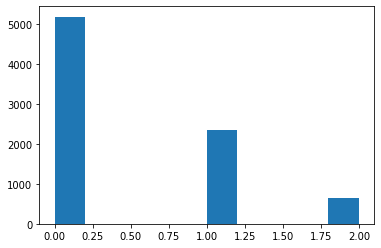

In [41]:
plt.figure()
plt.hist(y_test)
plt.show()

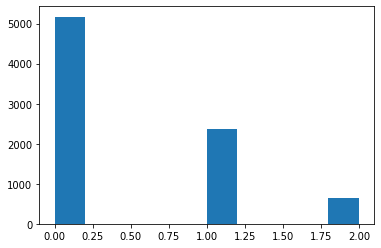

In [43]:
plt.figure()
plt.hist(y_pred)
plt.show()

In [44]:
arr_0 = (y_test == 0)
arr_1 = (y_test == 1)
arr_2 = (y_test == 2)

print(sum(arr_0))
print(sum(arr_1))
print(sum(arr_2))

5191
2344
650


In [45]:
arr_0 = (y_pred == 0)
arr_1 = (y_pred == 1)
arr_2 = (y_pred == 2)

print(sum(arr_0))
print(sum(arr_1))
print(sum(arr_2))

5172
2379
634
